In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [2]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [3]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2. glasso

# 2.1 get rid of seasonality

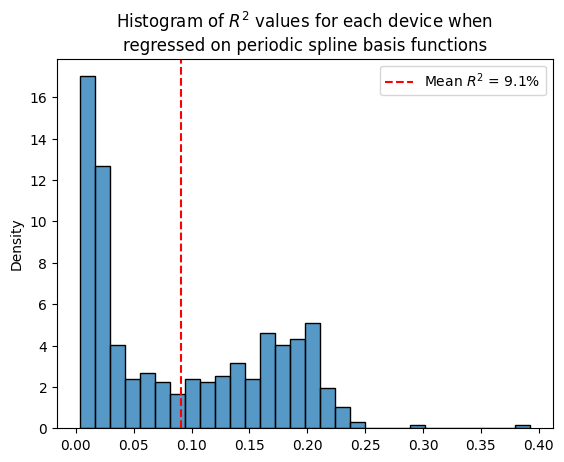

In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 8

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

r2s = pd.Series(r2s, index = df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")])
sns.histplot(r2s, bins = 30, stat = "density")
plt.title("Histogram of $R^2$ values for each device when\nregressed on periodic spline basis functions")
plt.axvline(r2s.mean(), color = "red", linestyle = "--", label = f"Mean $R^2$ = {r2s.mean() * 100:.1f}%")
plt.legend()

residuals = pd.concat(residuals, axis = 1)
df = residuals

# 2.2. correlations

<Axes: >

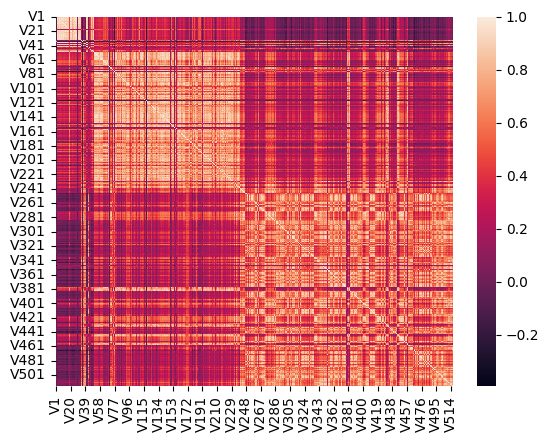

In [5]:
sns.heatmap(df.corr())

In [6]:
from joblib import Parallel, delayed
from sklearn.covariance import graphical_lasso

sublocs = locations[locations["latitude"] > 18]
sublocs = sublocs[sublocs["latitude"] < 26]
sublocs = sublocs[sublocs["longitude"] > 119]
sublocs = sublocs[sublocs["longitude"] < 123]


def get_precision(alpha):
    precision = graphical_lasso(df[sublocs.index.to_list()].corr(), alpha=alpha, mode="cd")[1]
    return precision


# plot the precision matrix
#alphas = [0.15, 0.5, 1]

#precisions = Parallel(n_jobs=4)(delayed(get_precision)(alpha) for alpha in alphas)
alpha = 0.95
precision = get_precision(alpha)

<Axes: xlabel='device', ylabel='device'>

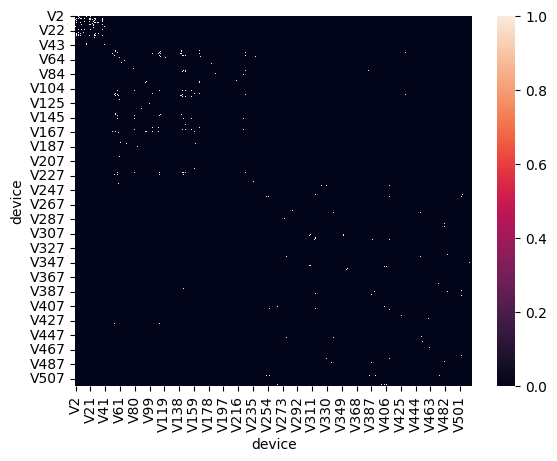

In [9]:
edge_weights = np.zeros((len(sublocs), len(sublocs)))

#num_edges = 50
# quantile of the absolute value of the precision matrix
#x = precision.copy()
#x[np.eye(x.shape[0], dtype=bool)] = 0
#THRESHOLD = np.sort(np.abs(x).ravel())[-num_edges]
#print(THRESHOLD)
THRESHOLD = 0.0001
for i in range(len(sublocs)):
    for j in range(i + 1, len(sublocs)):
        if np.abs(precision[i, j]) >= THRESHOLD:
            edge_weights[i, j] = 1
            edge_weights[j, i] = 1


edge_weights = pd.DataFrame(edge_weights, index=sublocs.index, columns=sublocs.index)

sns.heatmap(edge_weights)

/tmp/ipykernel_907417/2434426281.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/tmp/ipykernel_907417/2434426281.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([sublocs.loc[src, "longitude"], sublocs.loc[dst, "longitude"]],


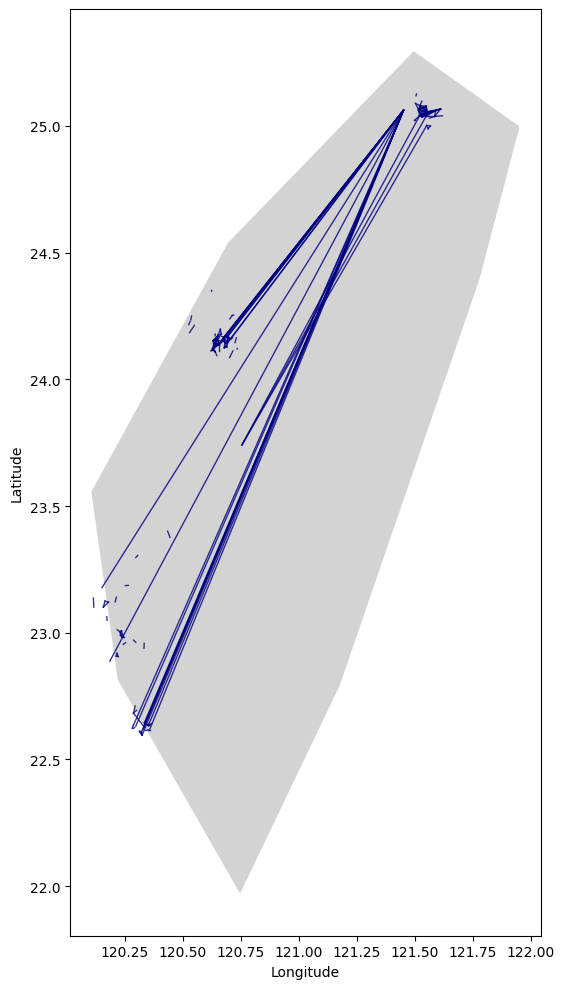

In [10]:
import geopandas as gpd

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# now we only plot rows  where df[["latitude", "longitude"]] is contained within the Taiwan polygon
sublocs = locations[locations["latitude"] > 18]
sublocs = sublocs[sublocs["latitude"] < 26]
sublocs = sublocs[sublocs["longitude"] > 119]
sublocs = sublocs[sublocs["longitude"] < 123]

countries[countries["name"] == "Taiwan"].plot(color="lightgrey", ax = ax)
#sns.scatterplot(data=sublocs, x="longitude", y="latitude", marker="x", color = "red", s=1000)

for i, src in enumerate(sublocs.index):
    for dst in sublocs.index[i:]:
        if edge_weights.loc[dst, src] != 0:
            plt.plot([sublocs.loc[src, "longitude"], sublocs.loc[dst, "longitude"]],
                     [sublocs.loc[src, "latitude"], sublocs.loc[dst, "latitude"]], "k-",
                     alpha=0.8, lw = 1, color = "navy")


# x and y axis labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

fig.tight_layout()
fig.savefig("../out/glasso_taiwan_line_only.png", dpi=300)
fig.show()